<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_bSSFP_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground/quantified_brain.npz &> /dev/null

(bSSFP_seq)=

# Imports and definitions

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
#@title Define SSFP in PyPulseq
# %% S2. DEFINE the sequence

FAex =60  #@param {type: "slider", min: 1, max: 180}
P_alpha_half= True #@param {type: "boolean"}
TR_ms =  0 #@param {type: "slider", min: 0.0, max: 20, step:0.1}
TR=TR_ms*1e-3
PEtype='linear'  #@param ['centric', 'linear']
PE_flag= True #@param {type: "boolean"}
TI =  0 #@param {type: "slider", min: 0, max: 5, step:0.1}

# choose the scanner limits
system = pp.Opts(max_grad=40,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=10e-6)
Nread = 64
Nphase= 64

seq = pp.Sequence(system)

# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3

# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

fastest_grad = pp.make_extended_trapezoid_area(area=(Nphase)/fov, channel='y', grad_end=0.0, grad_start=0.0, system=system)
min_gr_dur=fastest_grad[0].shape_dur  # this is a first speedup test, in shoudl run with area=(Nphase/2)/fov, but only area=(Nphase)/fov worked

dwell=3e-05

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=dwell*Nread, system=system)
adc = pp.make_adc(num_samples=Nread, duration=dwell*Nread, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=min_gr_dur, system=system)
gp = pp.make_trapezoid(channel='y', area=1, duration=min_gr_dur, system=system)

rf_phase = 0

# Define rf events
rf_IR= pp.make_block_pulse(
    flip_angle=  180* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3, system=system)
gz_spoil = pp.make_trapezoid(channel='z',area=64, duration=1e-3, system=system)

rfdur=0.8e-3
rf1, gz1, gzr1 = pp.make_sinc_pulse(
  flip_angle=FAex * np.pi / 180, duration=rfdur,
  slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
  system=system, return_gz=True)

rf0, gz0, gzr0 = pp.make_sinc_pulse(
  flip_angle=FAex/2* np.pi / 180, duration=rfdur,
  slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
  system=system, return_gz=True)

# ======
# CONSTRUCT SEQUENCE
# ======
##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
permvec =np.arange(0, Nphase, 1)
## centric reordering
if PEtype=='centric':
  permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
## random reordering
#perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

phenc_centr = phenc[permvec] *PE_flag

ktraj=np.array([])
if TI>0:
  seq.add_block(rf_IR)
  seq.add_block(gz_spoil)
  seq.add_block(pp.make_delay(TI))

seq.add_block(pp.make_delay(0.0015-(rfdur/2+rf1.delay)))

minTR=pp.calc_duration(gz1) + pp.calc_duration(gx_pre,gp,gzr1)+pp.calc_duration(gx)+pp.calc_duration(gp,gx_pre,gzr1)
minTR2=minTR/2
TRd=round(max(0, (TR/2-minTR2))/10e-5)*10e-5  # round to raster time
TR=2*(minTR2 +TRd)
if TRd==0:
  print('rep. time set to minTR [ms]',TR*1000)
else:
  print(' TR [ms]', TR*1000)

if P_alpha_half:
  seq.add_block(rf0,gz0)
  seq.add_block(gzr0)
  # last timing step is to add TR/2 between alpha half and first rf pulse
  # from pulse top to pulse top we have already played out one full gz0 and 2*gzr0, thus we substract these from TR
  seq.add_block(pp.make_delay(minTR2+TRd-pp.calc_duration(gz0)-2*pp.calc_duration(gzr0)))   #  for balancing Gz is played out twice!
  seq.add_block(gzr0)  #  balance Gz!
for ii in range(0, Nphase):  # e.g. -64:63

    rf_phase = divmod(rf_phase + 180, 360.0)[1]
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase, 180° alternating phase cycling
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC

    ktraj=np.append(ktraj,phenc_centr[ii])
    seq.add_block(rf1,gz1)
    gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=min_gr_dur, system=system)
    seq.add_block(pp.make_delay(TRd))

    seq.add_block(gx_pre, gp,gzr1)
    seq.add_block(adc, gx, pp.make_label(label="LIN", type="SET", value=permvec[ii]))
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=min_gr_dur, system=system)
    seq.add_block(gx_pre, gp,gzr1)  #  balance Gz!
    seq.add_block(pp.make_delay(TRd))
    # full pulse            delay of rf2 -ringdown rf1  + TR_delay + RO/2
#%% S3. CHECK, PLOT and WRITE the sequence  as .seq
#Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
   print('Timing check passed successfully')
else:
   print('Timing check failed. Error listing follows:')
   [print(e) for e in error_report]

# PLOT sequence
#sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition("RES", [Nread, Nphase, 1])
seq.write('external.seq')


rep. time set to minTR [ms] 3.9
Timing check passed successfully


/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95694/2161235286.py:39: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_IR= pp.make_block_pulse(
/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95694/2161235286.py:44: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz1, gzr1 = pp.make_sinc_pulse(
/var/folders/rr/w7cs6t1x0dl8cc5_ng28z6lr0000gp/T/ipykernel_95694/2161235286.py:49: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf0, gz0, gzr0 = pp.make_sinc_pulse(


'06791720fe7506c91dd7232b01f5a8b3'

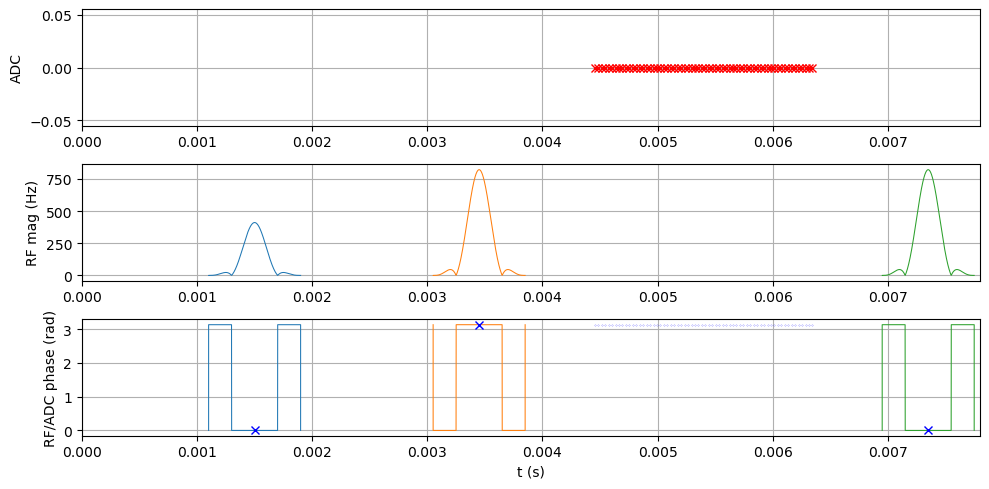

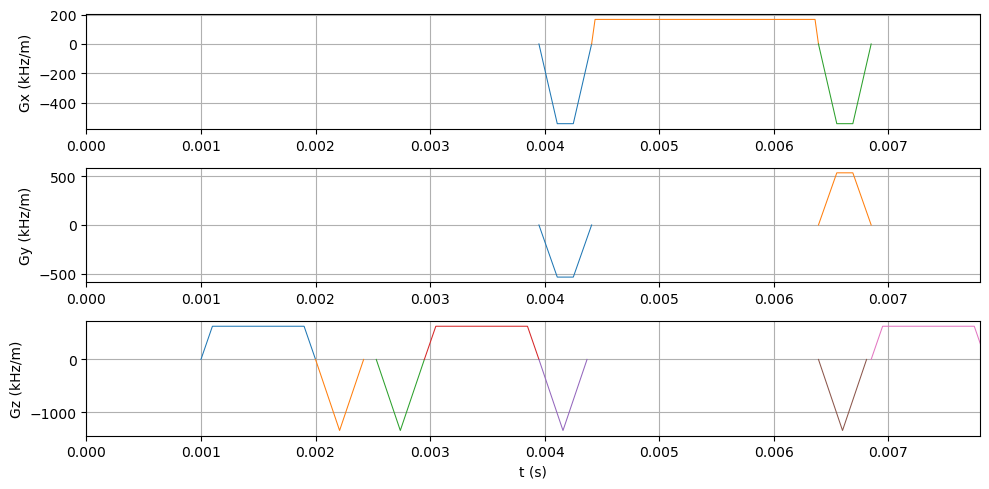

In [4]:
seq.plot(time_range=(0,2*TR))

# RUNs

/opt/homebrew/Caskroom/miniforge/base/envs/mri_p312/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741947704867/work/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.00108475 s
Compute Graph
Computing Graph: 0.010171792 s
Analyze Graph
Analyzing Graph: 0.000344709 s
Converting Rust -> Python: 0.007824708 s
<<<< Rust <<<<


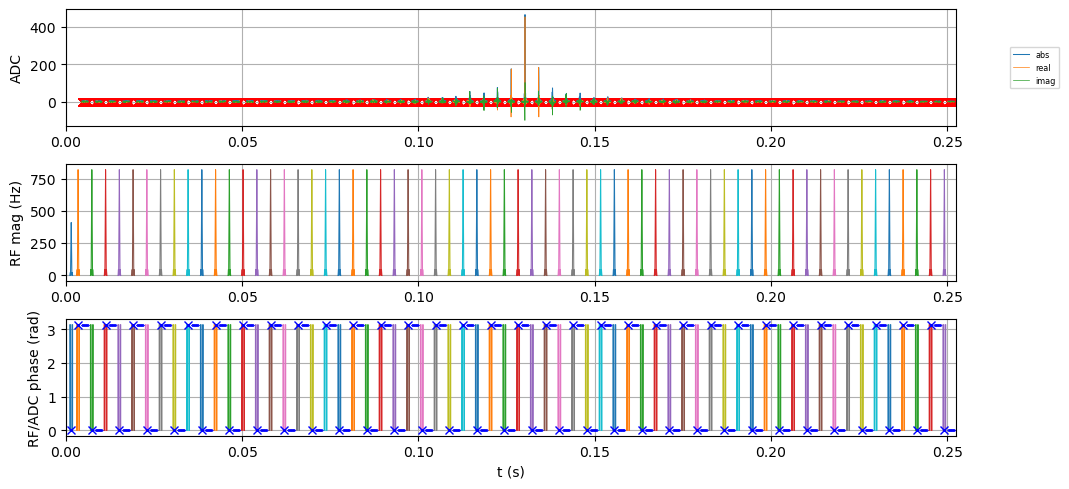

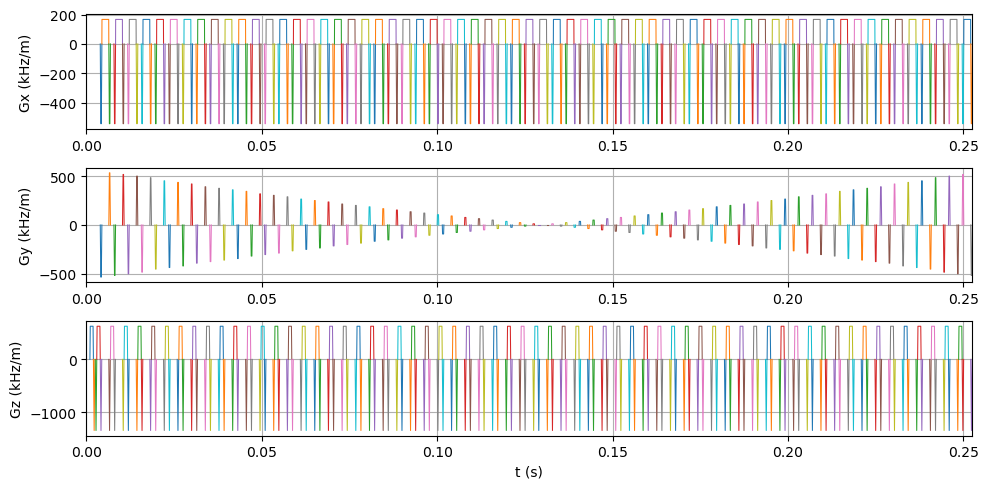

/opt/homebrew/Caskroom/miniforge/base/envs/mri_p312/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


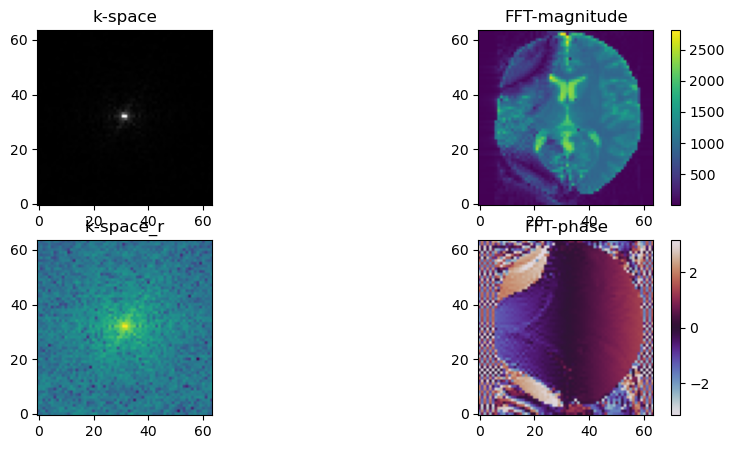

In [5]:
#@title S3 quick 2D brain phantom sim and plot
#signal = mr0.util.simulate_2d(seq)
# signal   = mr0.util.simulate_2d(seq,B0_scale=2, B0_polynomial=(0,0,-150,0,0,300))
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
data = mr0.util.load_phantom(size=(64, 64), dB0_fB0=(0, 2), B0_polynomial=[0, 0, -150, 0, 0, 300])
signal, _ = mr0.util.simulate(seq, data)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal=signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'bssfp_seq_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace_adc = torch.reshape(signal, (Nphase, Nread)).clone().t()
permvec=np.argsort(ktraj)
kspace=kspace_adc[:,permvec]
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()), cmap="gray")
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.colorbar()



In [6]:
import time


acc_array = [0.6, 0.5, 0.4, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.00001]
dt= np.zeros(len(acc_array))

space_3d = np.zeros((len(acc_array), Nread, Nphase), dtype=np.complex128)  # Adjust dimensions if needed

for i, acc in enumerate(acc_array):
    t0 = time.time()
    signal, _ = mr0.util.simulate(seq, data, accuracy=acc)
    t1 = time.time()
    dt[i] = t1 - t0

    kspace_adc = torch.reshape(signal, (Nphase, Nread)).T.clone()
    kspace=kspace_adc[:, np.argsort(ktraj)]
    # fftshift,FFT,fftshift
    space = torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(kspace)))
    space_3d[i] = space.numpy()  # Assuming 'space' is a PyTorch tensor
    print(f"Iteration {i + 1} with accuracy {acc:.6f} completed.")

print("All iterations finished. Data stored in 'space_3d'.")

plt.show()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000537709 s
Compute Graph
Computing Graph: 0.010016083 s
Analyze Graph
Analyzing Graph: 0.000430875 s
Converting Rust -> Python: 0.0075955 s
<<<< Rust <<<<
Iteration 1 with accuracy 0.600000 completed.
>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000323583 s
Compute Graph
Computing Graph: 0.009809625 s
Analyze Graph
Analyzing Graph: 0.000451208 s
Converting Rust -> Python: 0.007956208 s
<<<< Rust <<<<
Iteration 2 with accuracy 0.500000 completed.
>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000375167 s
Compute Graph
Computing Graph: 0.010024208 s
Analyze Graph
Analyzing Graph: 0.000325542 s
Converting Rust -> Python: 0.007207334 s
<<<< Rust <<<<
Iteration 3 with accuracy 0.400000 completed.
>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000251291 s
Compute Graph
Computing Graph: 0.010067292 s
Analyze Graph
Analyzing Graph: 0.00041925 s
Converting Rust -> Python: 0.0071

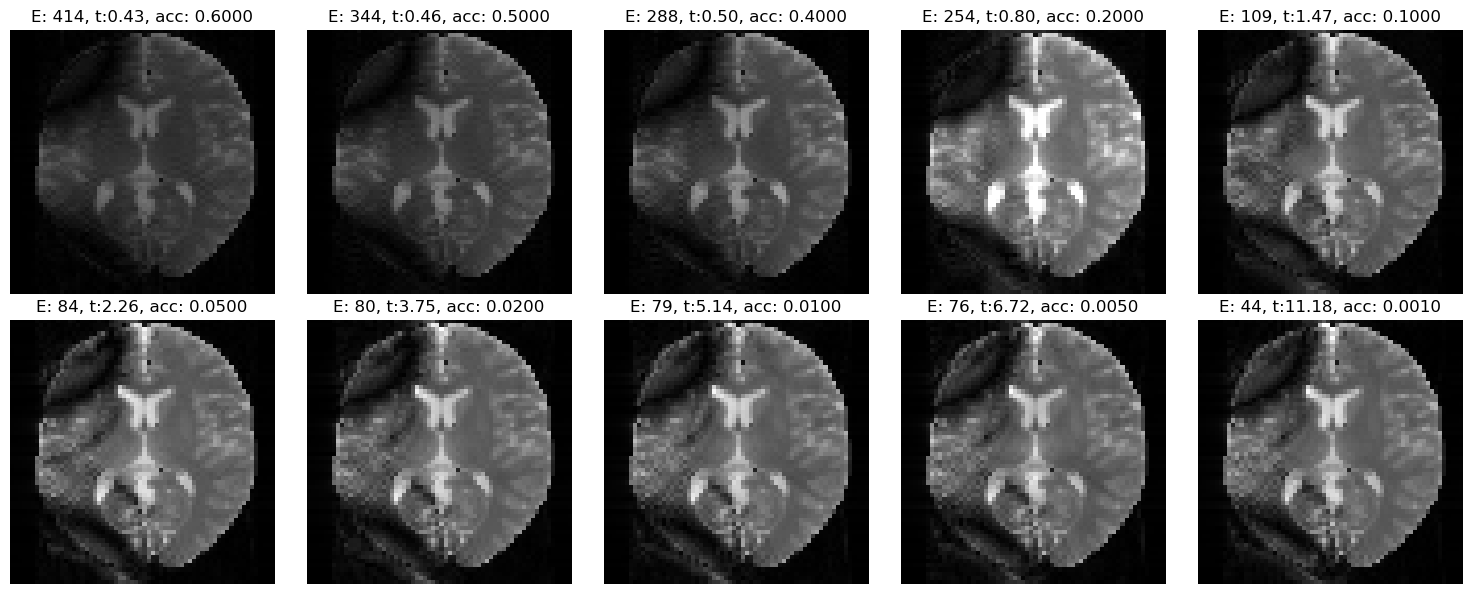

In [7]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 images
axes = axes.flatten()  # Flatten to a 1D array for easy iteration

# Assuming 'space_3d' is your 3D array of complex images
reference_image = np.abs(space_3d[-1])  # Last image as reference
vmax = np.max(np.abs(reference_image))

for i, ax in enumerate(axes):
    image = np.abs(space_3d[i])  # Absolute value of the current image
    rmse = np.sqrt(np.mean((image - reference_image)**2))  # Calculate RMSE
    ax.imshow(image.T, origin="lower",cmap='gray', vmax=vmax)
    ax.set_title(f"E: {rmse:.0f}, t:{dt[i]:.2f}, acc: {acc_array[i]:.4f}")
    ax.axis('off')


plt.tight_layout()


### Compare to existing reference

The next code just compares the outcome for different accuracies with a reference acquired in feb 2025 on CPU!

Data accuracies should be zero.

run time can vary, for the highest accuracy time discrepancy of ~(0.6511 %) was found in out test.

In [8]:
!wget https://github.com/MRsources/MRzero-Core/raw/refs/heads/main/documentation/playground_mr0/reference_bssfp_data_feb2025.npz &> /dev/null

if 0: # code used for storing the reference
  import os
  import numpy as np
  # Create directory if it doesn't exist
  data_to_save = {"space_3d": space_3d,"dt": dt, "acc_array":np.array(acc_array) }
  np.savez("reference_bssfp_data_feb2025.npz", **data_to_save)

if 1: # get stored reference
  with np.load('reference_bssfp_data_feb2025.npz') as data:
    space_3d_ref = data['space_3d']
    dt_ref = data['dt']
    acc_array_ref = data['acc_array']

print("Acc. \tMag_nrmse\tPhase_nrmse\ttnow \ttref \t(dt[s,%])")
for ii in range(len(acc_array)):

    # Compute absolute magnitude RMSE for space vs. space_wget
    abs_space_error = np.sqrt(np.mean((np.abs(space_3d[ii]) - np.abs(space_3d_ref[ii])) ** 2)) /np.mean(np.abs(space_3d[ii]))

    # Compute phase RMSE for space vs. space_wget
    phase_space_error = np.sqrt(np.mean((np.angle(space_3d[ii]) - np.angle(space_3d_ref[ii])) ** 2))

    # Compute RMSE for dt vs. dt_wget as direct difference
    e_dt_s = (dt[ii] - dt_ref[ii])
    e_dt_r = abs((dt[ii] - dt_ref[ii])) / dt_ref[ii] *100

    #print(f"Acc: {acc_array[ii]:.5f} -> Mag_rmse: {abs_space_error:.4f}, Phase_rmse: {phase_space_error:.4f}, run time: {e_dt:.4f}")
    print(f"{acc_array[ii]:.5f}\t{abs_space_error:.4f}\t\t{phase_space_error:.4f}\t\t{dt[ii] :.3f}s\t{dt_ref[ii] :.3f}s\t{e_dt_s:2.4f} ({e_dt_r:.4f} %)")


/opt/homebrew/Caskroom/miniforge/base/envs/mri_p312/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=95694) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Acc. 	Mag_nrmse	Phase_nrmse	tnow 	tref 	(dt[s,%])
0.60000	0.0000		0.0001		0.430s	0.775s	-0.3446 (44.4837 %)
0.50000	0.0000		0.0002		0.463s	0.900s	-0.4366 (48.5096 %)
0.40000	0.0000		0.0001		0.496s	1.044s	-0.5480 (52.4997 %)
0.20000	0.0000		0.0001		0.798s	1.130s	-0.3320 (29.3923 %)
0.10000	0.0000		0.0002		1.467s	1.538s	-0.0712 (4.6270 %)
0.05000	0.0000		0.0001		2.262s	2.236s	0.0261 (1.1696 %)
0.02000	0.0000		0.0001		3.747s	3.439s	0.3077 (8.9451 %)
0.01000	0.0000		0.0001		5.142s	5.112s	0.0303 (0.5930 %)
0.00500	0.0000		0.0001		6.715s	5.800s	0.9156 (15.7866 %)
0.00100	0.0000		0.0001		11.177s	9.740s	1.4372 (14.7548 %)
0.00001	0.0000		0.0001		16.099s	13.918s	2.1807 (15.6678 %)


In [9]:
# @title Save Signal to ISMRMRD file
import ismrmrd

mr0.sig_to_mrd("mr_zero.mrd", signal, seq, verbose=1)

Create ISMRMRD dataset at 'mr_zero.mrd'


Write readouts to mrd file: 100%|██████████| 64/64 [00:00<00:00, 1908.16acq/s]


In [10]:
# @title Read ISMRMRD file

dset = ismrmrd.Dataset("mr_zero.mrd", "dataset", create_if_needed=False)

mrd_header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

mrd_data_shape = (
    mrd_header.encoding[0].encodedSpace.matrixSize.x,
    mrd_header.encoding[0].encodedSpace.matrixSize.y,
    mrd_header.acquisitionSystemInformation.receiverChannels,
)

mrd_data = np.zeros(mrd_data_shape, dtype=np.complex64)
num_acq = dset.number_of_acquisitions()
for n_acq in range(num_acq):
    acq = dset.read_acquisition(n_acq)
    acq_head = acq.getHead()
    n_lin = acq_head.idx.kspace_encode_step_1

    mrd_data[:, n_lin, :] = acq.data.T

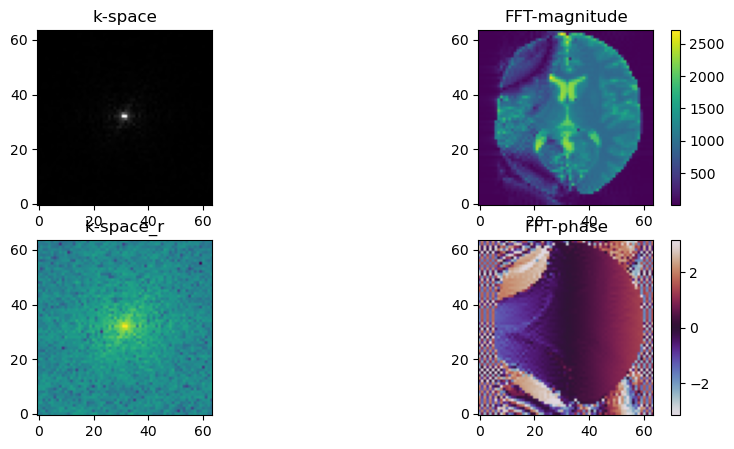

In [11]:
# @title Reconstruct image from ISMRMRD data
kspace = torch.from_numpy(mrd_data)
kspace = kspace[..., 0]  # take only first channel

# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace, dim=(0, 1))
space = torch.fft.fft2(spectrum, dim=(0, 1))
space = torch.fft.ifftshift(space, dim=(0, 1))

plt.subplot(221)
plt.title("k-space")
mr0.util.imshow(np.abs(kspace.numpy()), cmap="gray")
plt.subplot(223)
plt.title("k-space_r")
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title("FFT-magnitude")
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title("FFT-phase")
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.colorbar()
